<a href="https://colab.research.google.com/github/computablee/DS-5899-CS-5260-Final-Project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

sz = train_images.shape[1]
nclassout = 10

train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

In [ ]:
def relu_bn(inputs):
    relu = layers.ReLU()(inputs)
    bn = layers.BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x, downsample, filters, kernel_size = 3):
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = layers.Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)

    out = layers.Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
def create_res_net():
    inputs = layers.Input(shape=(sz, sz, 1))
    num_filters = 128
    
    t = layers.BatchNormalization()(inputs)
    t = layers.Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [4, 3, 2, 1]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = layers.AveragePooling2D(4)(t)
    t = layers.Flatten()(t)
    outputs = layers.Dense(10, activation='softmax')(t)
    
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

convnet = create_res_net()
convepochs = 15

In [ ]:
history = convnet.fit(train_images, train_labels_onehot, verbose=True, validation_split=.1, epochs=convepochs, batch_size=128)

Epoch 1/15
422/422 [==============================] - 34s 44ms/step - loss: 0.1314 - accuracy: 0.9631 - val_loss: 1.5572 - val_accuracy: 0.6667
Epoch 2/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.1185 - val_accuracy: 0.9703
Epoch 3/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0311 - accuracy: 0.9905 - val_loss: 0.0483 - val_accuracy: 0.9878
Epoch 4/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.0354 - val_accuracy: 0.9895
Epoch 5/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.0770 - val_accuracy: 0.9830
Epoch 6/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0388 - val_accuracy: 0.9913
Epoch 7/15
281/422 [==================>...........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9933

In [ ]:
def plot_loss(epochs, loss, val_loss):
    ep_titles = list(range(1, epochs + 1))
    ep_ticks = list(range(1, epochs + 1))
    
    plt.plot(ep_titles, loss, label="loss")
    plt.plot(ep_titles, val_loss, label="val_loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.suptitle("Loss as a Function of Epoch")
    plt.xticks(ep_ticks)
    plt.show()
    

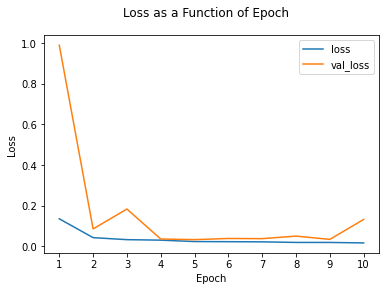

313/313 [==============================] - 2s 7ms/step - loss: 0.1029 - accuracy: 0.9723
Accuracy:  0.9722999930381775


In [ ]:
plot_loss(convepochs, history.history['loss'], history.history['val_loss'])

evaluation = convnet.evaluate(test_images, test_labels_onehot)
print("Accuracy: ", str(evaluation[1]))


In [ ]:
convnet.save('./mnist_convnet.hdf5')

In [ ]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(convnet.trainable_weights)
non_trainable_count = count_params(convnet.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 27,572,238
Trainable params: 27,558,668
Non-trainable params: 13,570
